In [1]:
!pip install ripser
!pip install scipy==1.10.1
#python version must be 3.8

In [ ]:
!pip install -U kaleido plotly


Please restart the session after running the above cell (Runtimme -> Restart session -> Yes)

Please upload **cup_length_utils.py**, **dreimac_utils.py**, and **dreimac_combinatorial.py** files to this Colab notebook. Below is what you should see on the left side of your notebook

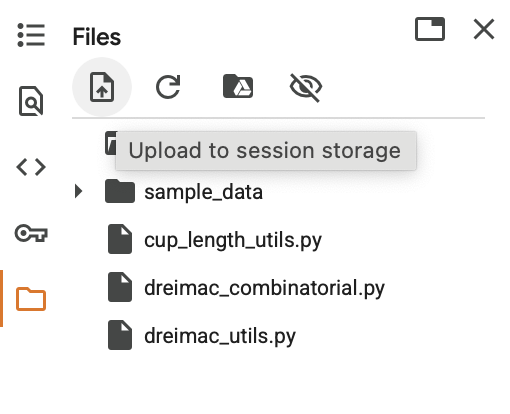



import our algorithm and key libraries

In [ ]:
from cup_length_utils import *
from dreimac_utils import *
from dreimac_combinatorial import *

import scipy
import plotly.graph_objs as go

Below is the main algorithm we will run on different point clouds. It computes persistent cup length matrix for a given point cloud and a choice of the number of landmarks. It returns the persistence diagrams, cup length 2 intervals, persistent cup length matrix as well as birth and death times of simplices in the VR filtraiton:

In [ ]:
def run_persistence_cup_length_algorithm(point_cloud, n_landmarks=150):

    # compute distance matrix from the point cloud
    d = pairwise_distances(point_cloud, metric='euclidean')

    # set threshold in the VR filtration
    threshold = np.max(d[~np.isinf(d)])

    # compute persistent homology on a subsampled point cloud.
    ripser_result = rips_filtration_diagram(data = d, distance_matrix = True, n_landmarks = n_landmarks, thresh = threshold)
    dgms = ripser_result['dgms']

    plot_diagrams(dgms, show=True)

    # set the minimum persistence to select the bars for which
    # we compute the cup product
    # min_persistence = 0 means we compute cup products between all available
    # 1-cocycles
    # min_persistence = compute_threshold_persistence(dgms[1]) means we select
    # the top two most persistent 1-cocycles \alpha and \beta and compute
    # \alpha \cup \alpha, \alpha \cup \beta, and \beta \cup \beta
    min_persistence = 0 #compute_threshold_persistence(dgms[1])

    print('Minimum persistence: ', min_persistence)

    t0 = time.time()
    # compute persistent cup length matrix
    (persistent_cup_length_matrix, b_times, d_times, cup_length_intervals) = compute_persistent_cup_length(2, \
                                                        ripser_result, \
                                                        d, \
                                                        min_persistence, \
                                                        threshold)




    t1 = time.time()

    elapsed_time = (t1 - t0) / 60  # Convert seconds to minutes

    print(f"Persistent cup length algorithm took {elapsed_time:.2f} minutes to run.")


    result_dict = plot_and_extract_staircase_polygons(
    persistent_cup_length_matrix,  dgms[1], b_times, d_times,
    facecolors={1: 'pink', 2: 'hotpink', 3: 'orange'},
    pointcolors={1: 'pink', 2: 'hotpink', 3: 'orange'},
    show_polygon_vertices=False
    )

    # Example: inspect cup-length 2 results
    cup2 = result_dict.get(2, {})
    print("Critical points (cup-length 2):", cup2.get('critical_points'))
    print("Polygon vertices (cup-length 2):", cup2.get('polygon'))


    return dgms, cup_length_intervals, persistent_cup_length_matrix, b_times, d_times

In [ ]:
def plot_and_extract_staircase_polygons(matrix, h1_dgms, births, deaths,
                                        diagonal_range=None,
                                        death_max=None,
                                        facecolors=None,
                                        pointcolors=None,
                                        alpha=0.3,
                                        show_polygon_vertices=False,
                                        show_cup_length_diagram=True,
                                        title='Cup-Length Diagram and Cup-Length Function'):
    """
    Compute and plot staircase polygons grouped by cup-length values from a matrix and birth/death data.

    Returns:
        {
            cup_length_val: {
                'diagram_points': [...],
                'critical_points': [...],
                'polygon': [...]
            },
            ...
        }
    """
    output = {}
    rows, cols = matrix.shape

    # Step 1: Group by cup-length value
    for i in range(rows):
        for j in range(cols):
            val = matrix[i, j]
            if val == 0:
                continue
            b, d = births[i], deaths[j]
            if d <= b:
                continue
            output.setdefault(val, {'diagram_points': []})
            output[val]['diagram_points'].append((b, d))


    for bar in h1_dgms:
        output.setdefault(1, {'diagram_points': []})
        output[1]['diagram_points'].append(tuple(bar))

    # Step 2: Compute staircase critical points and polygons
    for val, data in output.items():
        points = sorted(data['diagram_points'], key=lambda x: x[0])
        crit = []
        idx = 0
        while idx < len(points):
            b, d = points[idx]
            crit.append((b, d))
            idx += 1
            while idx < len(points) and points[idx][1] <= d:
                idx += 1
        data['critical_points'] = crit

        # Build staircase polygons
        all_polygons = []
        i = 0
        while i < len(crit):
            polygon = []
            b, d = crit[i]
            polygon.append((b, b))
            polygon.append((b, d))
            while i + 1 < len(crit) and crit[i + 1][0] <= d:
                b_next, d_next = crit[i + 1]
                polygon.append((b_next, d))
                polygon.append((b_next, d_next))
                d = d_next
                i += 1
            polygon.append((d, d))
            all_polygons.append(polygon)
            i += 1
        data['polygon'] = all_polygons

    # Step 3: Determine plot range from data if not provided
    all_points = [pt for group in output.values() for pt in group['diagram_points']]
    if not all_points:
        print("No diagram points to plot.")
        return output

    max_val = max(max(b, d) for b, d in all_points)
    if diagonal_range is None:
        diagonal_range = (0, max_val + 0.2)
    if death_max is None:
        death_max = max_val + 0.2

    # Step 4: Plot
    fig, ax = plt.subplots(figsize=(7, 6))
    ax.plot([*diagonal_range], [*diagonal_range], 'k--')

    label_added = set()
    for val, data in sorted(output.items()):
        if not data['diagram_points']:
            continue
        births_, deaths_ = zip(*data['diagram_points'])
        print('births_', births_)

        print('deaths_', deaths_)

        if show_cup_length_diagram:
            point_color = pointcolors.get(val, 'lightpink') if pointcolors else 'lightpink'
            label_pts = f'cup-length {int(val)} pts' if val not in label_added else None
            ax.scatter(births_, deaths_, s=15, color=point_color, label=label_pts)
        else:
            title = 'Cup-Length Function'

        for poly in data['polygon']:
            face_color = facecolors.get(val, 'pink') if facecolors else 'pink'
            label_poly = f'cup-length {int(val)}' if val not in label_added else None
            patch = patches.Polygon(poly, closed=True, facecolor=face_color,
                                    edgecolor='none', alpha=alpha, label=label_poly)
            ax.add_patch(patch)
            label_added.add(val)

        if show_polygon_vertices and data['critical_points']:
            crit_births, crit_deaths = zip(*data['critical_points'])
            ax.scatter(crit_births, crit_deaths, color='pink', s=10)

    ax.set_xlim(*diagonal_range)
    ax.set_ylim(0, death_max)
    ax.set_aspect('equal')
    # Set font sizes for labels and title
    ax.set_xlabel('Birth', fontsize=14)
    ax.set_ylabel('Death', fontsize=14)
    ax.set_title(title, fontsize=14)

    # Adjust tick label fonts
    ax.tick_params(axis='both', which='major', labelsize=14)

    # Adjust legend font size
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(fontsize=12)


    return output

# Standard torus  

We compute persistent cup length for a point cloud sampled from a torus. We sample 2,000 points from a torus with major radius $R=13$ and minor radius $r=7$. We visualize the point cloud, plot the persistence diagram, and then run our algorithm on this point cloud with 150 landmarks. We draw the resulting persistent cup length function.

We see that our algorithm detects a single cup length 2 interval, as expected from theory. This code was used to create the top panel of Figure 1 in our paper.

Computed rips filtration in 0.01 mins


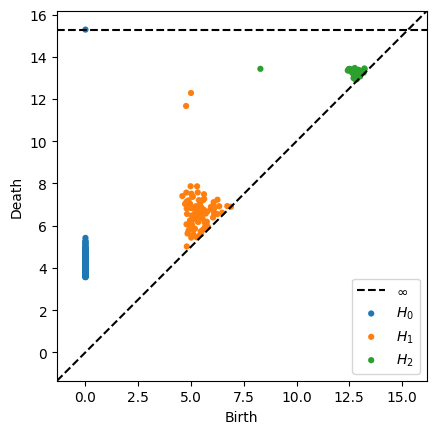

Minimum persistence:  0
cup length 2 interval: (8.287793159484863, 11.669621467590332)
Persistent cup length algorithm took 0.20 minutes to run.
births_ (8.287793159484863, 8.287793159484863, 12.427964210510254, 12.469673156738281, 12.487167358398438, 12.516247749328613, 12.516247749328613, 12.533061027526855, 12.533061027526855, 12.619529724121094, 12.659573554992676, 12.666224479675293, 12.700541496276855, 12.724254608154297, 12.73485279083252, 12.737557411193848, 12.749260902404785, 12.759160995483398, 12.777190208435059, 12.777190208435059, 12.852113723754883, 12.857460021972656, 12.857460021972656, 12.881324768066406, 12.885679244995117, 12.913856506347656, 12.937747955322266, 12.988287925720215, 13.014959335327148, 13.028904914855957, 13.033587455749512, 13.058478355407715, 13.181689262390137, 13.215798377990723, 13.223072052001953, 13.223072052001953, 6.891575336456299, 6.718623638153076, 6.477229595184326, 6.338441371917725, 6.255003929138184, 6.24775505065918, 6.13077354431152

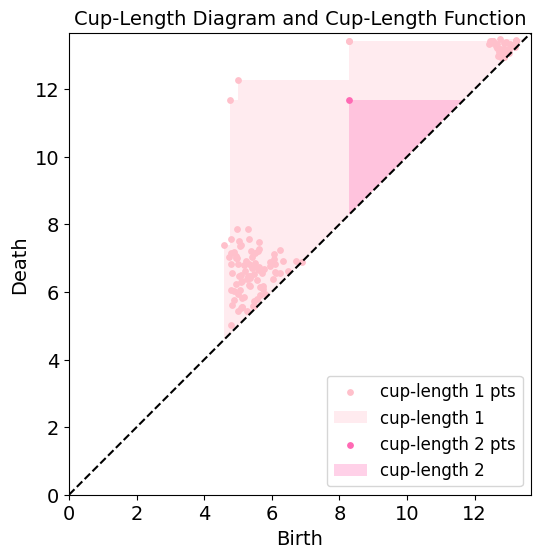

In [ ]:
n_points = 2000  # Number of points to sample
R = 13  # Major radius of the torus
r = 7  # Minor radius of the torus

np.random.seed(42)

# Sample points from a torus
torus_points = sample_torus(n_points, R, r)

# Visualize using Plotly's go.Figure
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=torus_points[:, 0],
    y=torus_points[:, 1],
    z=torus_points[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color='#ff69b4',
        opacity=0.8
    ),
    name=r'$S^1 \times S^1$'
))



fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
    ),
    margin=dict(l=0,r=0,b=0,t=30),
    paper_bgcolor='white',
)



fig.show()


dgms, cup_lengths_2, persistent_cup_length_matrix, b_times, d_times = run_persistence_cup_length_algorithm(torus_points, 150)

Below is a visualization of the cup length computation, showing two most persistent 1-bars in orange, the most persistent 2-bar in green, and the resulting cup length 2 interval in black.

In [ ]:
def plot_persistent_homology_barcodes(ph_data, cup_interval=None, y_offset=2, bar_spacing=0.3):
    color_cycle = ['#FF8C00', 'green', 'black']

    plt.figure(figsize=(8, 4))
    max_x = 0

    # Dictionary to store endpoints of bars for vertical lines
    bar_ends = {
        'orange': [],  # store all H0 bars
        'green': []    # store all H1 bars
    }

    # Plot each homology dimension
    for dim, arr in enumerate(ph_data):
        # Sort by persistence
        if arr.size > 0:
            persistence = arr[:, 1] - arr[:, 0]
            idx_sorted = np.argsort(persistence)[::-1]
            sorted_arr = arr[idx_sorted]
        else:
            sorted_arr = arr

        n = len(sorted_arr)
        y_base = -dim * y_offset

        if n > 0:
            offsets = np.linspace(-bar_spacing * (n - 1) / 2,
                                  bar_spacing * (n - 1) / 2,
                                  n)
            y_positions = y_base + offsets

            color = color_cycle[dim % len(color_cycle)]
            for i, ((b, d), y) in enumerate(zip(sorted_arr, y_positions)):
                plt.hlines(y, b, d, color=color, linewidth=2)
                max_x = max(max_x, d)

                if dim == 0:
                    if i < 2:
                        label = r"$\alpha$" if i == 0 else r"$\beta$"
                        plt.text(d + 0.1, y, label, va='center', fontsize=16)
                    bar_ends['orange'].append((b, d, y))

                if dim == 1:
                    bar_ends['green'].append((b, d, y))

        plt.text(-1, y_base, f"$H_{{{dim + 1}}}$", va='center', fontsize=16, fontweight='bold')

    # Always reserve label position for Cup length 2
    y_cup = -len(ph_data) * y_offset
    plt.text(-3.5, y_cup, "Cup length 2", va='center', fontsize=16)

    if cup_interval is not None:
        cup_left, cup_right = cup_interval
        plt.hlines(y_cup, cup_left, cup_right, color='black', linewidth=2)
        max_x = max(max_x, cup_right)

        # Find matching orange bar ending at cup_right
        for (b, d, y) in bar_ends['orange']:
            if np.isclose(d, cup_right):
                plt.vlines(cup_right, y_cup, y, linestyle='dotted', color='black', linewidth=1.5)
                break

        # Find matching green bar starting at cup_left
        for (b, d, y) in bar_ends['green']:
            if np.isclose(b, cup_left):
                plt.vlines(cup_left, y_cup, y, linestyle='dotted', color='black', linewidth=1.5)
                break

    # Axes and limits

    top_offset = 0
    if ph_data and len(ph_data[0]) > 1:
        top_offset = bar_spacing * (len(ph_data[0]) - 1) / 2
    y_top = 0 + top_offset
    plt.ylim(y_cup - 0.5, y_top + 0.5)
    plt.xlabel("Lifespan", fontsize=16)  # Increase font size of x-axis label
    plt.xticks(fontsize=12)              # Increase font size of x-axis tick labels
    plt.yticks([], fontsize=12)
    plt.xlim(0, max_x + 1)
    plt.yticks([])

    plt.tight_layout()
    plt.show()


def top_persistent_bars(dgm, top_k):
    return sorted(dgm, key=lambda x: x[1] - x[0], reverse=True)[:top_k]

# Extract top persistent bars
top_H1 = top_persistent_bars(dgms[1], 2)  # Top 2 from H1
top_H2 = top_persistent_bars(dgms[2], 1)  # Top 1 from H2


ph_data = [
    np.array(top_H1),  # H1
    np.array(top_H2)   # H2
]

plot_persistent_homology_barcodes(ph_data, cup_interval=cup_lengths_2[0])

# Torus with geodesic metric

We model the flat torus as $T^2 = S^1 \times S^1$, with each point represented by angles $(\theta, \phi) \in [0, 2\pi)^2$. The intrinsic distance is defined by the product of circular geodesics:

$$
d((\theta_1, \phi_1), (\theta_2, \phi_2)) = \sqrt{d_{S^1}(\theta_1, \theta_2)^2 + d_{S^1}(\phi_1, \phi_2)^2},
$$

where $d_{S^1}(\alpha, \beta) = \min(|\alpha - \beta|, 2\pi - |\alpha - \beta|)$ is the arc distance on the circle. We compute persistent homology using the Vietoris–Rips complex built from this metric with 150 landmarks (`n_perm=150`). The resulting diagram typically shows two long H1 bars (capturing the torus generators) and one H2 bar (corresponding to the 2-dimensional void).



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import plotly.graph_objects as go

import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import shortest_path
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt

import random
random.seed(42)

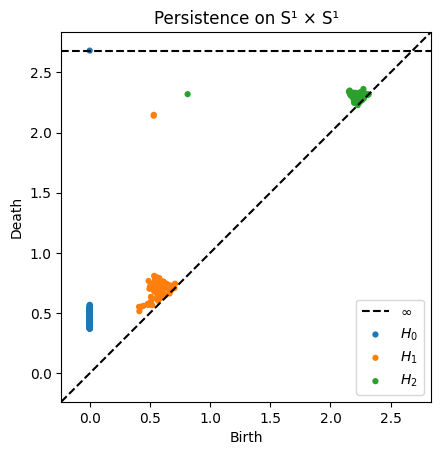

dim 1 persistence diagram:
Birth: 0.5326, Death: 2.1472, Length: 1.6146
Birth: 0.5313, Death: 2.1398, Length: 1.6085
dim 2 persistence diagram:
Birth: 0.8133, Death: 2.3188, Length: 1.5055


In [ ]:
def sample_torus_angles(n_points):
    theta = 2 * np.pi * np.random.rand(n_points)
    phi = 2 * np.pi * np.random.rand(n_points)
    return np.column_stack((theta, phi))

# Embed flat torus (S¹ × S¹) into ℝ³ using standard embedding
def embed_flat_torus(angles, R=7, r=2.0):
    theta, phi = angles[:, 0], angles[:, 1]
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    return np.column_stack((x, y, z))

def torus_distance_matrix(angles):
    n = angles.shape[0]
    D = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            d_theta = np.abs(angles[i, 0] - angles[j, 0])
            d_phi = np.abs(angles[i, 1] - angles[j, 1])
            d_theta = min(d_theta, 2 * np.pi - d_theta)
            d_phi = min(d_phi, 2 * np.pi - d_phi)
            D[i, j] = D[j, i] = np.sqrt(d_theta ** 2 + d_phi ** 2)
    return D

angles = sample_torus_angles(n_points=3000)
D = torus_distance_matrix(angles)
dgms = ripser(D, maxdim=2, distance_matrix=True, n_perm = 150)['dgms']
plot_diagrams(dgms, show=True, title="Persistence on S¹ × S¹")

print("dim 1 persistence diagram:")
bars = dgms[1]
lengths = bars[:, 1] - bars[:, 0]
for i in np.argsort(-lengths)[:2]:
    print(f"Birth: {bars[i,0]:.4f}, Death: {bars[i,1]:.4f}, Length: {lengths[i]:.4f}")

print("dim 2 persistence diagram:")
bars = dgms[2]
lengths = bars[:, 1] - bars[:, 0]
for i in np.argsort(-lengths)[:1]:
    print(f"Birth: {bars[i,0]:.4f}, Death: {bars[i,1]:.4f}, Length: {lengths[i]:.4f}")

# Visualize the flat torus in 3D using Plotly
torus_points = embed_flat_torus(angles)
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=torus_points[:, 0],
    y=torus_points[:, 1],
    z=torus_points[:, 2],
    mode='markers',
    marker=dict(size=2, color='#ff69b4', opacity=0.8),
    name='Flat Torus (S¹ × S¹)'
))

fig.update_layout(
    scene=dict(xaxis=dict(visible=False),
               yaxis=dict(visible=False),
               zaxis=dict(visible=False)),
    margin=dict(l=0, r=0, t=30, b=0),
    title="Flat Torus Embedded in ℝ³"
)

fig.show()
np.save('torus_points.npy', torus_points)
np.save('torus_distance_matrix.npy', D)

We used above code to create the torus shown in Figure 1 of our paper. Note that due to random sampling the above code may produce different outputs. The exact point cloud that we used can be downloaded as follows:

In [ ]:
# torus points
loaded_torus_points = np.load('torus_points.npy') #!
# torus distance matrix
torus_D = np.load('torus_distance_matrix.npy') #fig1_dataset/


(1000, 1000)

We then run our persistent cup length analysis:

Computed rips filtration in 0.01 mins


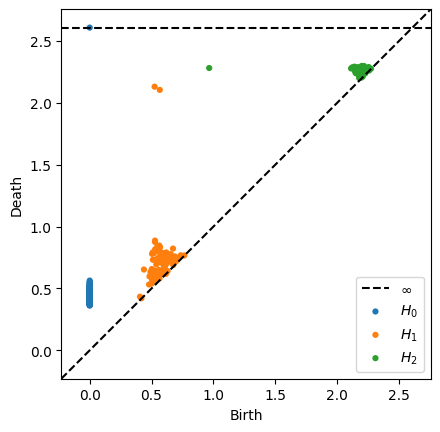

Minimum persistence:  0
cup length 2 interval: (0.9658657908439636, 2.1052396297454834)
Persistent cup length algorithm took 2.45 minutes to run.
births_ (0.9658657908439636, 2.1130053997039795, 2.1221983432769775, 2.1350276470184326, 2.1401448249816895, 2.1417365074157715, 2.146364688873291, 2.14874529838562, 2.14874529838562, 2.1493003368377686, 2.1506731510162354, 2.1511051654815674, 2.1517839431762695, 2.152085542678833, 2.157128095626831, 2.1572844982147217, 2.1577413082122803, 2.1589837074279785, 2.1621668338775635, 2.163968563079834, 2.1642837524414062, 2.1654865741729736, 2.166564464569092, 2.1667609214782715, 2.171659469604492, 2.172114133834839, 2.17252516746521, 2.1728036403656006, 2.1749253273010254, 2.1753053665161133, 2.1769115924835205, 2.1779792308807373, 2.178159236907959, 2.1786608695983887, 2.1911652088165283, 2.193392038345337, 2.1962757110595703, 2.196368455886841, 2.1982362270355225, 2.198439598083496, 2.201965093612671, 2.2048733234405518, 2.2067418098449707, 2.2

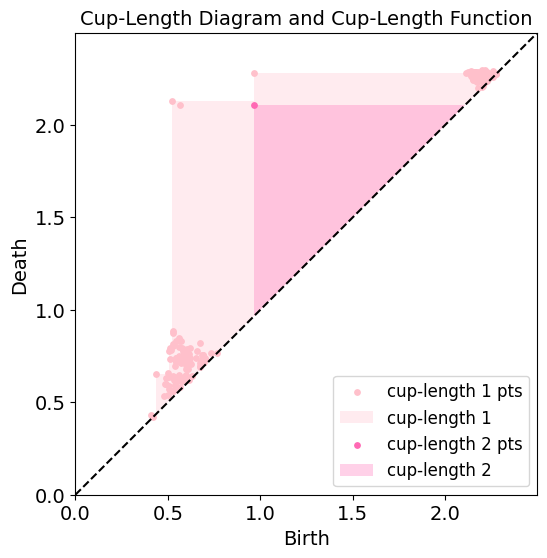

In [ ]:

n_landmarks = 150
threshold = np.max(torus_D[~np.isinf(torus_D)])

# compute persistent homology on a subsampled point cloud.
ripser_result = rips_filtration_diagram(data = torus_D, distance_matrix = True, n_landmarks = n_landmarks, thresh = threshold)
dgms = ripser_result['dgms']

plot_diagrams(dgms, show=True)

# set the minimum persistence to select the bars for which
# we compute the cup product
# min_persistence = 0 means we compute cup products between all available
# 1-cocycles
# min_persistence = compute_threshold_persistence(dgms[1]) means we select
# the top two most persistent 1-cocycles \alpha and \beta and compute
# \alpha \cup \alpha, \alpha \cup \beta, and \beta \cup \beta
min_persistence = 0 #compute_threshold_persistence(dgms[1])

print('Minimum persistence: ', min_persistence)

t0 = time.time()
# compute persistent cup length matrix
(persistent_cup_length_matrix, b_times, d_times, cup_length_intervals) = compute_persistent_cup_length(2, \
                                                    ripser_result, \
                                                    torus_D, \
                                                    min_persistence, \
                                                    threshold)




t1 = time.time()

elapsed_time = (t1 - t0) / 60  # Convert seconds to minutes

print(f"Persistent cup length algorithm took {elapsed_time:.2f} minutes to run.")


result_dict = plot_and_extract_staircase_polygons(
persistent_cup_length_matrix,  dgms[1], b_times, d_times,
facecolors={1: 'pink', 2: 'hotpink', 3: 'orange'},
pointcolors={1: 'pink', 2: 'hotpink', 3: 'orange'},
show_polygon_vertices=False
)

# Example: inspect cup-length 2 results
cup2 = result_dict.get(2, {})
print("Critical points (cup-length 2):", cup2.get('critical_points'))
print("Polygon vertices (cup-length 2):", cup2.get('polygon'))



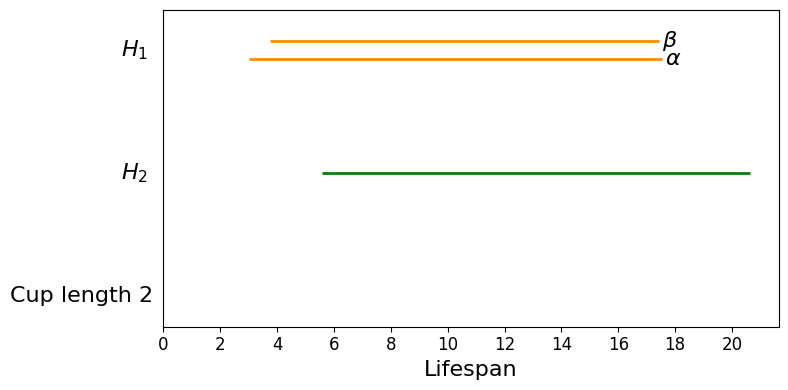

In [ ]:
import matplotlib.ticker as ticker

# Force integer x-axis tick labels


def plot_persistent_homology_barcodes(ph_data, cup_interval=None, y_offset=2, bar_spacing=0.3):


    color_cycle = ['#FF8C00', 'green', 'black']

    plt.figure(figsize=(8, 4))
    max_x = 0

    # Dictionary to store endpoints of bars for vertical lines
    bar_ends = {
        'orange': [],  # store all H0 bars
        'green': []    # store all H1 bars
    }

    # Plot each homology dimension
    for dim, arr in enumerate(ph_data):
        # Sort by persistence
        if arr.size > 0:
            persistence = arr[:, 1] - arr[:, 0]
            idx_sorted = np.argsort(persistence)[::-1]
            sorted_arr = arr[idx_sorted]
        else:
            sorted_arr = arr

        n = len(sorted_arr)
        y_base = -dim * y_offset

        if n > 0:
            offsets = np.linspace(-bar_spacing * (n - 1) / 2,
                                  bar_spacing * (n - 1) / 2,
                                  n)
            y_positions = y_base + offsets

            color = color_cycle[dim % len(color_cycle)]
            for i, ((b, d), y) in enumerate(zip(sorted_arr, y_positions)):
                plt.hlines(y, b, d, color=color, linewidth=2)
                max_x = max(max_x, d)

                if dim == 0:
                    if i < 2:
                        label = r"$\alpha$" if i == 0 else r"$\beta$"
                        plt.text(d + 0.1, y, label, va='center', fontsize=16)
                    bar_ends['orange'].append((b, d, y))

                if dim == 1:
                    bar_ends['green'].append((b, d, y))

        plt.text(-1.5, y_base, f"$H_{{{dim + 1}}}$", va='center', fontsize=16, fontweight='bold')

    # Always reserve label position for Cup length 2
    y_cup = -len(ph_data) * y_offset
    plt.text(-5.4, y_cup, "Cup length 2", va='center', fontsize=16)
    #plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    if cup_interval is not None:
        cup_left, cup_right = cup_interval
        plt.hlines(y_cup, cup_left, cup_right, color='black', linewidth=2)
        max_x = max(max_x, cup_right)

        # Find matching orange bar ending at cup_right
        for (b, d, y) in bar_ends['orange']:
            if np.isclose(d, cup_right):
                plt.vlines(cup_right, y_cup, y, linestyle='dotted', color='black', linewidth=1.5)
                break

        # Find matching green bar starting at cup_left
        for (b, d, y) in bar_ends['green']:
            if np.isclose(b, cup_left):
                plt.vlines(cup_left, y_cup, y, linestyle='dotted', color='black', linewidth=1.5)
                break

    # Axes and limits

    top_offset = 0
    if ph_data and len(ph_data[0]) > 1:
        top_offset = bar_spacing * (len(ph_data[0]) - 1) / 2
    y_top = 0 + top_offset
    plt.ylim(y_cup - 0.5, y_top + 0.5)
    plt.xlabel("Lifespan", fontsize=16)  # Increase font size of x-axis label
    plt.xticks(fontsize=12)              # Increase font size of x-axis tick labels
    plt.yticks([], fontsize=12)
    plt.xlim(0, max_x + 1)
    plt.yticks([])
    plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))
    plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{int(x)}"))
    plt.tight_layout()
    plt.show()


def top_persistent_bars(dgm, top_k):
    return sorted(dgm, key=lambda x: x[1] - x[0], reverse=True)[:top_k]

# Extract top persistent bars
top_H1 = top_persistent_bars(dgms[1], 2)  # Top 2 from H1
top_H2 = top_persistent_bars(dgms[2], 1)  # Top 1 from H2


ph_data = [
    np.array(top_H1),  # H1
    np.array(top_H2)   # H2
]

plot_persistent_homology_barcodes(ph_data, cup_interval=None)

#  Mickey mouse
Here, we apply our algorithm to a point cloud sampled from $S^1 \vee S^2 \vee S^1 $. Although  $S^1 \vee S^2 \vee S^1 $ share the same homology with a torus, $S^1 \vee S^2 \vee S^1 $ has cup length 1 while a torus has cup length 2. Our algorithm indeed doesn't detect cup length 2 in $S^1 \vee S^2 \vee S^1 $:

Computed rips filtration in 0.03 mins


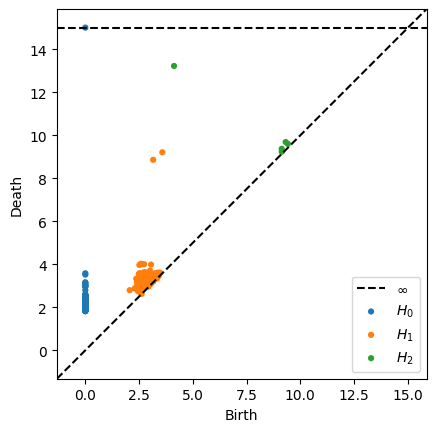

Minimum persistence:  0
Persistent cup length algorithm took 1.16 minutes to run.
births_ (4.125804901123047, 9.136307716369629, 9.136307716369629, 9.136307716369629, 9.136307716369629, 9.319034576416016, 9.420496940612793, 3.582305431365967, 3.476389169692993, 3.410977363586426, 3.3849945068359375, 3.3292837142944336, 3.2900965213775635, 3.2595911026000977, 3.181957483291626, 3.164583444595337, 3.155959367752075, 3.111154794692993, 3.0868241786956787, 3.073740243911743, 3.0730643272399902, 3.056666135787964, 3.0518836975097656, 3.038198471069336, 3.0239555835723877, 3.012373208999634, 2.943481206893921, 2.942272901535034, 2.9400646686553955, 2.939871072769165, 2.9283058643341064, 2.926722526550293, 2.926565408706665, 2.9187867641448975, 2.907996892929077, 2.870929718017578, 2.8525445461273193, 2.8231029510498047, 2.81758713722229, 2.78472638130188, 2.77604603767395, 2.7708053588867188, 2.7704861164093018, 2.7584235668182373, 2.7418928146362305, 2.73988676071167, 2.735686779022217, 2.7

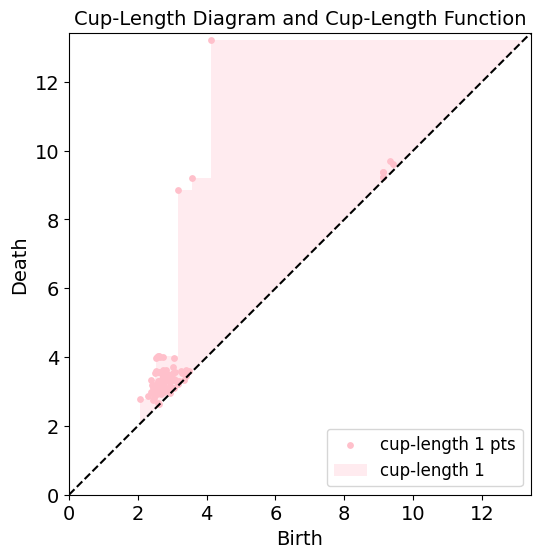

In [ ]:
def generate_s1_s2_s1_point_cloud(n_phi=50, n_theta=50, n_circle=500,
                                  sphere_radius=4.50, circle1_radius=0.4, circle2_radius=0.4):
    """
    Generates a point cloud for S^1 ∨ S^2 ∨ S^1: a sphere with two attached circles.
    The circles are oriented in the radial direction so that the plane of each circle
    contains the radial (normal) vector of the sphere at the attachment point.

    Parameters:
      n_phi, n_theta : int
          Resolution parameters for the sphere (S²).
      n_circle : int
          Number of points used to generate each circle (S¹).
      sphere_radius : float
          Radius of the sphere.
      circle_radius : float
          Radius of the circles.

    Returns:
      point_cloud : (N x 3) numpy array
          Combined point cloud for the sphere and both circles.
    """
    # 1. Generate sphere (S²) points using spherical coordinates
    n_points = 1000
    # Sample azimuthal angle uniformly between 0 and 2π
    phi = np.random.uniform(0, 2 * np.pi, n_points)

    # Sample z-coordinate uniformly between -1 and 1
    z = np.random.uniform(-1, 1, n_points)

    # Compute the radius in the x-y plane for each z
    r = sphere_radius * np.sqrt(1 - z**2)

    # Convert spherical coordinates to Cartesian coordinates
    x_sphere = r * np.cos(phi)
    y_sphere = r * np.sin(phi)
    z_sphere = sphere_radius * z

    # Combine the coordinates into an (n_points x 3) array
    sphere_points = np.column_stack((x_sphere, y_sphere, z_sphere))

    # 2. Define attachment points on the sphere (ensure they lie on the sphere)
    p_left = np.array([-0.6, 0.8, 0.0])
    p_left = sphere_radius * p_left / np.linalg.norm(p_left)
    p_right = np.array([0.6, 0.8, 0.0])
    p_right = sphere_radius * p_right / np.linalg.norm(p_right)

    # 3. Generate a circle that goes in the radial direction.
    #    The circle will be attached at the sphere (at 'center') such that for t=0,
    #    the circle passes through the attachment point.
    angles = np.linspace(0, 2 * np.pi, n_circle)

    def radial_circle(center, circle_radius, angles):
        """
        Generate a circle in a plane containing the radial direction (from the origin).
        The circle is constructed so that one point (for t=0) equals the attachment point.
        """
        # Radial (normal) vector at the attachment point
        n = center / np.linalg.norm(center)
        # Pick an arbitrary vector perpendicular to n.
        if np.allclose(n, [0, 0, 1]):
            u = np.array([1, 0, 0])
        else:
            u = np.cross(n, [0, 0, 1])
            u /= np.linalg.norm(u)
        # Offset the circle's center along the radial direction so that
        # the point corresponding to t=0 is the attachment point.
        # Let circle_center = attachment point + circle_radius * n.
        circle_center = center + circle_radius * n
        # Parameterize the circle in the plane spanned by -n and u.
        # At t=0: cos(0)=1 and sin(0)=0 gives:
        # circle_center + circle_radius*(-n) = center.
        circle_points = np.array([
            circle_center + circle_radius * (np.cos(t) * (-n) + np.sin(t) * u)
            for t in angles
        ])
        return circle_points

    circle_left = radial_circle(p_left, circle1_radius, angles)
    circle_right = radial_circle(p_right, circle2_radius, angles)

    # 4. Combine sphere and circles into one point cloud
    point_cloud = np.vstack([sphere_points, circle_left, circle_right])
    return point_cloud


# Generate the point cloud
bunny_point_cloud = generate_s1_s2_s1_point_cloud(sphere_radius=8, circle1_radius=5, circle2_radius=5.1)


# Visualize using Plotly's go.Figure
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=bunny_point_cloud[:, 0],
    y=bunny_point_cloud[:, 1],
    z=bunny_point_cloud[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color='#ff69b4',
        opacity=0.8
    ),
    name=r'$S^1 \vee S^1 \vee S^1$'
))



fig.update_layout(
    title=r'Point Cloud for $S^1 \vee S^2 \vee S^1$ (Radial Circles)',
    scene=dict(
        xaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        yaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        zaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        )
    ),
    paper_bgcolor="white",
    plot_bgcolor="white"
)

fig.update_layout(
    scene=dict(
        aspectmode='manual',    # <— force equal scaling on x,y,z
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
    ),
    margin=dict(l=0,r=0,b=0,t=30),
    paper_bgcolor='white',
)

fig.show()


#dgms, cup_lengths_2, persistent_cup_length_matrix, b_times, d_times = run_persistence_cup_length_algorithm(bunny_point_cloud, 150)

# Mickey mouse (ellipsoid verision)

To allow some flexibility in the shapes we are considering, we decided to also look at $S^1 \vee S^2 \vee S^1 $ where $S^2$ is realized geometrically as an ellipsoid. This additional degree of freedom allowed us to generate a $S^1 \vee S^2 \vee S^1 $ point cloud whose persistence diagram looked very similar to the persistence diagram of a torus. This code was used to generate the bottom plot of Figure 1 in our paper (note that Figure 1 shows the point cloud using a top-down projection).


We model $S^1 \vee S^2 \vee S^1$ as a 3D point cloud consisting of a prolate ellipsoid and two radial circles. The ellipsoid replaces the 2-sphere and has semi-axes $(aR, bR, cR)$, with two attachment points selected on its surface. At each point, a circle is placed orthogonally in 3D space.

We generate the point cloud using 1000 samples on the ellipsoid and 500 samples per circle, with `sphere_radius = 1.3`, `circle_radius = 1.2`, and axis scaling $(1, 1, 2.5)$.

Using the **Euclidean distance** in $\mathbb{R}^3$, we compute persistent homology on the point cloud with 150 landmark points (`n_perm=150`). The diagrams typically reveal two long $H_1$ bars from the circles and one $H_2$ bar from the ellipsoidal body.


In [ ]:
def generate_s1_s2_s1_point_cloud_ellipsoid(
    n_sphere=1000,
    n_circle=500,
    sphere_radius=4.5,
    circle_radius=0.4,
    axes=(1.0, 1.0, 1.0)
):
    """
    Generates a point cloud for S^1 ∨ S^2 ∨ S^1, but with the 'sphere' replaced
    by an ellipsoid whose semi-axes are sphere_radius * axes[i].

    Parameters
    ----------
    n_sphere : int
        Number of points to sample on the ellipsoid surface.
    n_circle : int
        Number of points per attached circle.
    sphere_radius : float
        Base radius (before axis scaling).
    circle_radius : float
        Radius of the attached circles.
    axes : tuple of 3 floats
        Multiplicative scales along (x, y, z). For a true sphere use (1,1,1).

    Returns
    -------
    point_cloud : (N,3) array
        Combined ellipsoid + two circles.
    """
    a, b, c = axes
    # 1) sample unit-sphere directions
    phi = np.random.uniform(0, 2*np.pi, size=n_sphere)
    cos_theta = np.random.uniform(-1, 1, size=n_sphere)
    sin_theta = np.sqrt(1 - cos_theta**2)
    # unit-sphere coords
    x_u = sin_theta * np.cos(phi)
    y_u = sin_theta * np.sin(phi)
    z_u = cos_theta
    # scale to ellipsoid
    x_e = sphere_radius * a * x_u
    y_e = sphere_radius * b * y_u
    z_e = sphere_radius * c * z_u
    sphere_pts = np.column_stack((x_e, y_e, z_e))

    # 2) pick two attachment points (on the ellipsoid surface)
    #    choose them first on the unit sphere, then scale
    attach_dirs = [np.array([-0.6, 0.8, 0.0]),
                   np.array([ 0.6, 0.8, 0.0])]
    ellip_attach = []
    for v in attach_dirs:
        u = v / np.linalg.norm(v)
        # map to ellipsoid surface along the ray
        # solve t * [a u_x, b u_y, c u_z] = point, with norm direction u
        # we want t so that point lies on ellipsoid: (t a u_x)^2 + ... = (sphere_radius)^2
        # => t = sphere_radius / sqrt((a u_x)^2+(b u_y)^2+(c u_z)^2)
        denom = np.sqrt((a*u[0])**2 + (b*u[1])**2 + (c*u[2])**2)
        pt = (sphere_radius / denom) * u
        ellip_attach.append(pt)
    p_left, p_right = ellip_attach

    # 3) radial circle generator (same as before, but center in ellipsoidal metric)
    angles = np.linspace(0, 2*np.pi, n_circle, endpoint=False)
    def radial_circle(center, circle_radius, angles):
        nrm = center / np.linalg.norm(center)
        # pick perpendicular u
        if np.allclose(nrm, [0,0,1]):
            u = np.array([1,0,0])
        else:
            u = np.cross(nrm, [0,0,1])
            u /= np.linalg.norm(u)
        # center of the small circle
        circ_c = center + circle_radius * nrm
        return np.stack([
            circ_c + circle_radius*(np.cos(t)*(-nrm) + np.sin(t)*u)
            for t in angles
        ], axis=0)

    circle_left  = radial_circle(p_left,  circle_radius, angles)
    circle_right = radial_circle(p_right, circle_radius, angles)

    # 4) combine
    return np.vstack([sphere_pts, circle_left, circle_right])

circle_radius = 1.2
sphere_radius = 1.3

# Generate the point cloud
bunny_point_cloud = generate_s1_s2_s1_point_cloud_ellipsoid(sphere_radius=sphere_radius, circle_radius=circle_radius, axes=(1.0, 1.0, 2.5))

dgms = ripser(bunny_point_cloud, maxdim=2, n_perm = 150)['dgms']
plot_diagrams(dgms, show=True, title= "Persistence on S1 ∨ S2 ∨ S1")

print("dim 1 persistence diagram:")
bars = dgms[1]
lengths = bars[:, 1] - bars[:, 0]
for i in np.argsort(-lengths)[:2]:
    print(f"Birth: {bars[i,0]:.4f}, Death: {bars[i,1]:.4f}, Length: {lengths[i]:.4f}")

print("dim 2 persistence diagram:")
bars = dgms[2]
lengths = bars[:, 1] - bars[:, 0]
for i in np.argsort(-lengths)[:1]:
    print(f"Birth: {bars[i,0]:.4f}, Death: {bars[i,1]:.4f}, Length: {lengths[i]:.4f}")

# Visualize using Plotly's go.Figure
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=bunny_point_cloud[:, 0],
    y=bunny_point_cloud[:, 1],
    z=bunny_point_cloud[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color='#ff69b4',
        opacity=0.8
    ),
    name=r'$S^1 \vee S^1 \vee S^1$'
))

fig.update_layout(
    title=r'Point Cloud for $S^1 \vee S^2 \vee S^1$ (Radial Circles)',
    scene=dict(
        xaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        yaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        zaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        )
    ),
    paper_bgcolor="white",
    plot_bgcolor="white"
)

fig.update_layout(
    scene=dict(
        aspectmode='manual',    # <— force equal scaling on x,y,z
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
    ),
    margin=dict(l=0,r=0,b=0,t=30),
    paper_bgcolor='white',
)

fig.show()

NameError: name 'run_persistence_cup_length_algorithm' is not defined

Note that due to random sampling the above code may produce different outputs. The exact point cloud used to create Figure 1 in our paper can be loaded as follows:

In [ ]:
loaded_micky_points = np.load('fig1_dataset/mickey_mouse_points.npy')

We then run our persistent cup length analysis:

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=loaded_micky_points[:, 0],
    y=loaded_micky_points[:, 1],
    z=loaded_micky_points[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color='#ff69b4',
        opacity=0.8
    ),
    name=r'$S^1 \vee S^1 \vee S^1$'
))

fig.update_layout(
    title=r'Point Cloud for $S^1 \vee S^2 \vee S^1$ (Radial Circles)',
    scene=dict(
        xaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        yaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        zaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        )
    ),
    paper_bgcolor="white",
    plot_bgcolor="white"
)

fig.update_layout(
    scene=dict(
        aspectmode='manual',    # <— force equal scaling on x,y,z
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
    ),
    margin=dict(l=0,r=0,b=0,t=30),
    paper_bgcolor='white',
)

fig.show()

mickey_mouse_d = pairwise_distances(loaded_micky_points, metric='euclidean')

dgms, cup_lengths_2, persistent_cup_length_matrix, b_times, d_times = run_persistence_cup_length_algorithm(mickey_mouse_d, 150)

# Mickey mouse (glued metric)


We construct a wedge sum space $X = S^1_1 \vee S^2 \vee S^1_2$, where each component is endowed with its standard intrinsic metric (arc length on $S^1$, geodesic on $S^2$), and all are glued at a common basepoint $x_0$. The distance between points is defined as follows:

* **Within the same component**: use the intrinsic geodesic distance.
* **Between components**: for $x \in A$, $y \in B$, define

$$
d(x, y) = d_A(x, x_0) + d_B(y, x_0).
$$

This defines a path metric on the glued space that treats all transitions between components as routed through the basepoint. We approximate geodesics on the ellipsoid using a k-nearest neighbor graph with Dijkstra’s algorithm and use exact arc distances on the circles. The full glued distance matrix is then used to compute Vietoris–Rips persistence with 150 landmarks (`n_perm=150`). The resulting diagram typically reveals two prominent H1 bars (from the two $S^1$ loops) and one H2 bar (from the $S^2$ component).

In [ ]:
from scipy.spatial.distance import cdist
from scipy.sparse.csgraph import shortest_path


def sample_circle(n_points, radius=1.0):
    angles = np.linspace(0, 2 * np.pi, n_points, endpoint=False)
    x = radius * np.cos(angles)
    y = radius * np.sin(angles)
    return np.stack([x, y], axis=1)

def sample_ellipsoid(n_points, radius=1.0, axes=(1.0, 1.0, 1.0)):
    a, b, c = axes
    phi = np.random.uniform(0, 2 * np.pi, size=n_points)
    cos_theta = np.random.uniform(-1, 1, size=n_points)
    sin_theta = np.sqrt(1 - cos_theta ** 2)

    x = radius * a * sin_theta * np.cos(phi)
    y = radius * b * sin_theta * np.sin(phi)
    z = radius * c * cos_theta
    return np.stack([x, y, z], axis=1)

def geodesic_distance_circle(X):
    n = X.shape[0]
    dists = np.zeros((n, n))
    arc_lengths = np.linalg.norm(X[1] - X[0]) * n
    for i in range(n):
        for j in range(n):
            d = abs(i - j)
            dists[i, j] = min(d, n - d) * arc_lengths / n
    return dists

def geodesic_distance_sphere(X, k=10):
    from sklearn.neighbors import NearestNeighbors
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)
    distances, indices = nbrs.kneighbors(X)

    n = X.shape[0]
    graph = np.full((n, n), np.inf)
    for i in range(n):
        for j, dist in zip(indices[i], distances[i]):
            graph[i, j] = dist
            graph[j, i] = dist
    return shortest_path(graph, directed=False)


# Sample components
n_sphere = 2000
n_circle = 500

sphere_pts = sample_ellipsoid(n_sphere, radius=5.8, axes=(1.0, 1.0, 4.0))
circle1_pts = np.pad(sample_circle(n_circle, radius=5.2), ((0, 0), (0, 1)))  # embed in R^3
circle2_pts = np.pad(sample_circle(n_circle, radius=4.9), ((0, 0), (0, 1)))  # embed in R^3

# Basepoints (we'll use index 0 for each)
x0_sph = sphere_pts[0]
x0_c1 = circle1_pts[0]
x0_c2 = circle2_pts[0]

# Compute internal geodesic distances
D_sph = geodesic_distance_sphere(sphere_pts, k=10)
D_c1 = geodesic_distance_circle(circle1_pts)
D_c2 = geodesic_distance_circle(circle2_pts)

# Compute distances from each point to its basepoint
d_sph_to_base = D_sph[:, 0]
d_c1_to_base = D_c1[:, 0]
d_c2_to_base = D_c2[:, 0]

# Build full glued distance matrix
N1, N2, N3 = n_sphere, n_circle, n_circle
N = N1 + N2 + N3
D = np.zeros((N, N))

# Fill diagonal blocks
D[:N1, :N1] = D_sph
D[N1:N1+N2, N1:N1+N2] = D_c1
D[N1+N2:, N1+N2:] = D_c2

# Fill off-diagonal blocks using gluing metric
# Sphere to Circle1
D[:N1, N1:N1+N2] = d_sph_to_base[:, None] + d_c1_to_base[None, :]
D[N1:N1+N2, :N1] = D[:N1, N1:N1+N2].T

# Sphere to Circle2
D[:N1, N1+N2:] = d_sph_to_base[:, None] + d_c2_to_base[None, :]
D[N1+N2:, :N1] = D[:N1, N1+N2:].T

# Circle1 to Circle2
D[N1:N1+N2, N1+N2:] = d_c1_to_base[:, None] + d_c2_to_base[None, :]
D[N1+N2:, N1:N1+N2] = D[N1:N1+N2, N1+N2:].T

# Run persistent homology
dgms = ripser(D, distance_matrix=True, maxdim=2, n_perm = 150)['dgms']

# Plot diagram
plot_diagrams(dgms, show=True, title="Persistence diagram of S^1 ∨ S^2 ∨ S^1 (glued metric)")

print("dim 1 persistence diagram:")
bars = dgms[1]
lengths = bars[:, 1] - bars[:, 0]
for i in np.argsort(-lengths)[:2]:
    print(f"Birth: {bars[i,0]:.4f}, Death: {bars[i,1]:.4f}, Length: {lengths[i]:.4f}")

print("dim 2 persistence diagram:")
bars = dgms[2]
lengths = bars[:, 1] - bars[:, 0]
for i in np.argsort(-lengths)[:1]:
    print(f"Birth: {bars[i,0]:.4f}, Death: {bars[i,1]:.4f}, Length: {lengths[i]:.4f}")


np.save('mickey_mouse_D.npy', D)

Below code was used to create the  S^1 ∨ S^2 ∨ S^1 subplot in Figure 1 in our paper:

Computed rips filtration in 0.01 mins


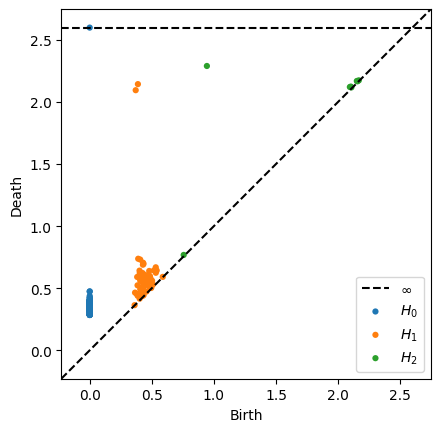

Minimum persistence:  1.0356167703866959
Persistent cup length algorithm took 3.85 minutes to run.
births_ (0.7569364309310913, 0.9437711238861084, 2.0952606201171875, 2.1031553745269775, 2.1076276302337646, 2.1514296531677246, 2.156698226928711, 2.1672556400299072, 0.5881325602531433, 0.5396507382392883, 0.5324605107307434, 0.5320166945457458, 0.5174380540847778, 0.5094509124755859, 0.5022274851799011, 0.4960814416408539, 0.4953947365283966, 0.49239861965179443, 0.4887058436870575, 0.4854412376880646, 0.4845629334449768, 0.4829775094985962, 0.4819961190223694, 0.47935137152671814, 0.47918227314949036, 0.4775705337524414, 0.4768046438694, 0.4749976694583893, 0.4733806848526001, 0.47263333201408386, 0.46510595083236694, 0.4629553258419037, 0.4590592384338379, 0.4563600420951843, 0.4552335739135742, 0.45484527945518494, 0.4456365406513214, 0.44421881437301636, 0.4416118562221527, 0.44020864367485046, 0.43739405274391174, 0.43667206168174744, 0.43465298414230347, 0.4340587258338928, 0.433

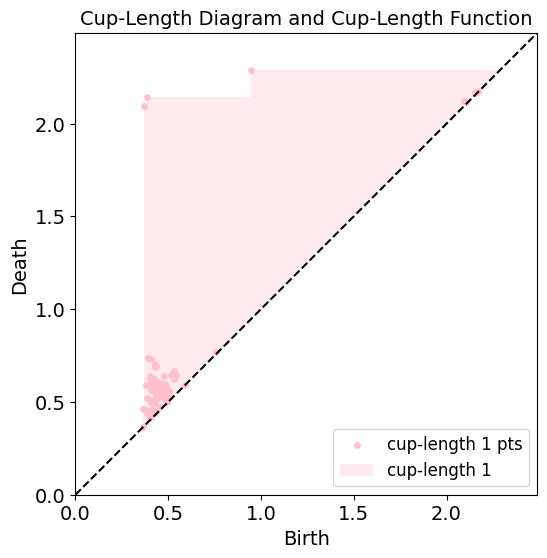

In [ ]:
mickey_mouse_D_glued_metric = np.load('fig1_dataset/mickey_mouse_D_final_for_real.npy')

n_landmarks = 150
threshold = np.max(mickey_mouse_D_glued_metric[~np.isinf(mickey_mouse_D_glued_metric)])

# compute persistent homology on a subsampled point cloud.
ripser_result = rips_filtration_diagram(data = mickey_mouse_D_glued_metric, distance_matrix = True, n_landmarks = n_landmarks, thresh = threshold)
dgms = ripser_result['dgms']

plot_diagrams(dgms, show=True)

# set the minimum persistence to select the bars for which
# we compute the cup product
# min_persistence = 0 means we compute cup products between all available
# 1-cocycles
# min_persistence = compute_threshold_persistence(dgms[1]) means we select
# the top two most persistent 1-cocycles \alpha and \beta and compute
# \alpha \cup \alpha, \alpha \cup \beta, and \beta \cup \beta
min_persistence = compute_threshold_persistence(dgms[1])

print('Minimum persistence: ', min_persistence)

t0 = time.time()
# compute persistent cup length matrix
(persistent_cup_length_matrix, b_times, d_times, cup_length_intervals) = compute_persistent_cup_length(2, \
                                                    ripser_result, \
                                                    mickey_mouse_D_glued_metric, \
                                                    min_persistence, \
                                                    threshold)




t1 = time.time()

elapsed_time = (t1 - t0) / 60  # Convert seconds to minutes

print(f"Persistent cup length algorithm took {elapsed_time:.2f} minutes to run.")


result_dict = plot_and_extract_staircase_polygons(
persistent_cup_length_matrix,  dgms[1], b_times, d_times,
facecolors={1: 'pink', 2: 'hotpink', 3: 'orange'},
pointcolors={1: 'pink', 2: 'hotpink', 3: 'orange'},
show_polygon_vertices=False
)

# Example: inspect cup-length 2 results
cup2 = result_dict.get(2, {})
print("Critical points (cup-length 2):", cup2.get('critical_points'))
print("Polygon vertices (cup-length 2):", cup2.get('polygon'))




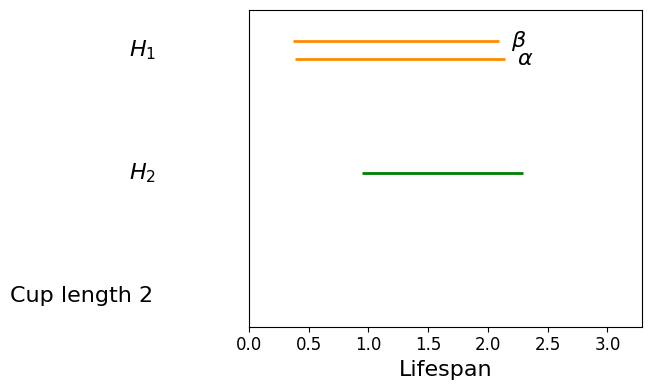

In [ ]:


def top_persistent_bars(dgm, top_k):
    return sorted(dgm, key=lambda x: x[1] - x[0], reverse=True)[:top_k]

# Extract top persistent bars
top_H1 = top_persistent_bars(dgms[1], 2)  # Top 2 from H1
top_H2 = top_persistent_bars(dgms[2], 1)  # Top 1 from H2


ph_data = [
    np.array(top_H1),  # H1
    np.array(top_H2)   # H2
]

plot_persistent_homology_barcodes(ph_data, cup_interval=None)

# Torus with circles attached

In this example, we consider a torus with a few circles attached to it (i.e. $T^2 \vee S^1 \vee S^1 \vee ...$). From theory, we expect the cup length to be unaffected by the attachment of the circles (i.e. we expect $T^2$ and $T^2 \vee S^1 \vee S^1 \vee ...$ both have the same cup length 2 interval).  

This code was used to create Figure 2 in our paper.

Computed rips filtration in 0.01 mins


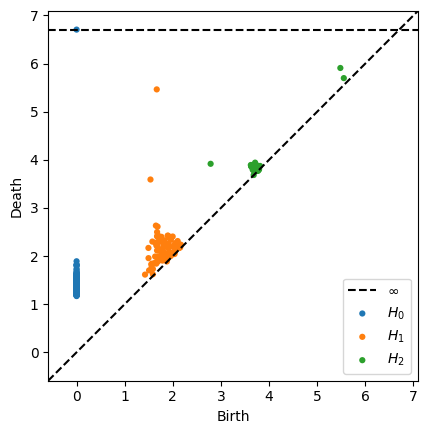

Minimum persistence:  0
cup length 2 interval: (2.785768985748291, 3.5911474227905273)
Persistent cup length algorithm took 0.69 minutes to run.


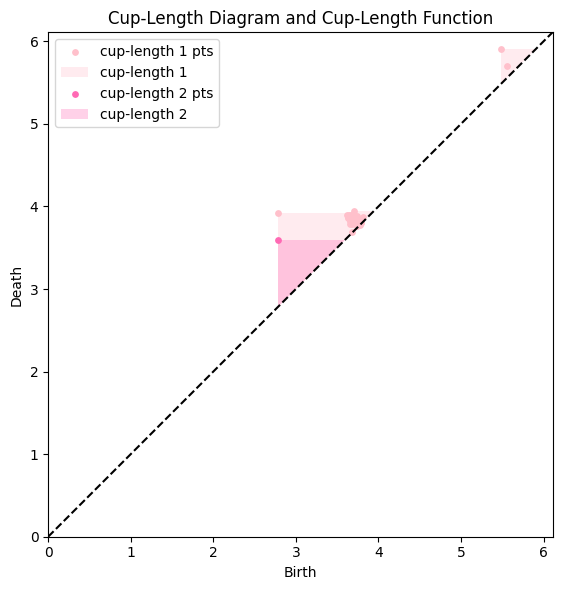

Critical points (cup-length 2): [(2.785768985748291, 3.5911474227905273)]
Polygon vertices (cup-length 2): [[(2.785768985748291, 2.785768985748291), (2.785768985748291, 3.5911474227905273), (3.5911474227905273, 3.5911474227905273)]]


In [ ]:
np.random.seed(42)

def sample_torus(n_points, R, r):
    """
    Randomly sample points on a torus.

    Parameters:
      n_points : int
          Number of points to sample.
      R : float
          Major radius of the torus.
      r : float
          Minor radius (tube radius).

    Returns:
      (n_points x 3) numpy array of sampled points.
    """
    theta = 2 * np.pi * np.random.random(n_points)
    phi = 2 * np.pi * np.random.random(n_points)
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    return np.column_stack((x, y, z))

def uniform_torus_attachment_points(n, R, r):
    """
    Generate n nearly-uniform attachment points on a torus along with their normals.

    We use an irrational rotation method so that the points (given in torus parameters u and v)
    are well distributed.

    Parameters:
      n : int
          Number of attachment points.
      R : float
          Major radius.
      r : float
          Minor radius.

    Returns:
      points : (n x 3) numpy array of attachment points on the torus.
      normals : (n x 3) numpy array of unit normal vectors at the attachment points.

    For a torus parametrized by
       x = (R + r*cos(v))*cos(u),
       y = (R + r*cos(v))*sin(u),
       z = r*sin(v),
    the outward normal is given by
       n = (cos(v)*cos(u), cos(v)*sin(u), sin(v)).
    """
    phi_ratio = (np.sqrt(5) + 1) / 2  # golden ratio
    i = np.arange(n)
    u = 2 * np.pi * ((i * (1/phi_ratio)) % 1)
    v = 2 * np.pi * ((i * (1/phi_ratio**2)) % 1)
    x = (R + r * np.cos(v)) * np.cos(u)
    y = (R + r * np.cos(v)) * np.sin(u)
    z = r * np.sin(v)
    points = np.column_stack((x, y, z))
    normals = np.column_stack((np.cos(v) * np.cos(u),
                                np.cos(v) * np.sin(u),
                                np.sin(v)))
    return points, normals

def generate_torus_with_circles(n_torus_points=1000, n_circle=100,
                                R=5.0, r=1.0, circle_radius=0.4, n_circles=2):
    """
    Generates a point cloud for a torus with n attached circles.

    The torus is generated by randomly sampling points from its parametric equations.
    Then, n attachment points (with normals) are computed via an irrational rotation
    method, and at each attachment point a circle is generated in the plane determined by
    the surface normal. The circle is offset so that its t=0 point touches the torus.

    Parameters:
      n_torus_points : int
          Number of points to sample for the torus.
      n_circle : int
          Number of points used to sample each circle.
      R : float
          Major radius of the torus.
      r : float
          Minor radius (tube radius) of the torus.
      circle_radius : float
          Radius of each attached circle.
      n_circles : int
          Number of circles to attach.

    Returns:
      point_cloud : (N x 3) numpy array combining the torus and circle points.
    """
    # 1. Generate the torus point cloud.
    torus_points = sample_torus(n_torus_points, R, r)

    # 2. Generate n attachment points on the torus and their normals.
    attachment_points, normals = uniform_torus_attachment_points(n_circles, R, r)

    # 3. Function to generate a radial circle at an attachment point.
    angles = np.linspace(0, 2 * np.pi, n_circle)

    def radial_circle(center, circle_radius, angles, normal):
        """
        Generate a circle in the plane containing the surface normal at 'center'.
        The circle is constructed so that for t=0 the point is exactly the attachment point.
        """
        n_vec = normal  # assumed to be unit
        # Choose an arbitrary vector perpendicular to n_vec.
        if np.allclose(n_vec, [0, 0, 1]):
            u_vec = np.array([1, 0, 0])
        else:
            u_vec = np.cross(n_vec, [0, 0, 1])
            u_vec /= np.linalg.norm(u_vec)
        # Offset so that at t=0, circle_center + circle_radius*(-n_vec) equals center.
        circle_center = center + circle_radius * n_vec
        circle_points = np.array([
            circle_center + circle_radius * (np.cos(t) * (-n_vec) + np.sin(t) * u_vec)
            for t in angles
        ])
        return circle_points

    # 4. Generate circles at each attachment point.
    circles = []
    for center, normal in zip(attachment_points, normals):
        circle_pts = radial_circle(center, circle_radius, angles, normal)
        circles.append(circle_pts)
    circles_points = np.vstack(circles)

    # 5. Combine the torus and the circles into one point cloud.
    point_cloud = np.vstack([torus_points, circles_points])
    return point_cloud



# Attach n circles to the torus
point_cloud = generate_torus_with_circles(
    n_torus_points=2000,
    n_circle=300,
    R=5.0,
    r=2.0,
    circle_radius=1,
    n_circles=1
)


# Visualize using Plotly
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=point_cloud[:, 0],
    y=point_cloud[:, 1],
    z=point_cloud[:, 2],
    mode='markers',
    marker=dict(size=2, color='#ff69b4', opacity=0.8),
    name='Torus with Circles Attached'
))



fig.update_layout(
    title=r' Torus with n Circles Attached',
    scene=dict(
        xaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        yaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        zaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        )
    ),
    paper_bgcolor="white",
    plot_bgcolor="white"
)

fig.show()


dgms, cup_lengths_2, persistent_cup_length_matrix, b_times, d_times = run_persistence_cup_length_algorithm(point_cloud, 150)



Below is a visualization of the cup length computation, showing two most persistent 1-bars in orange, the most persistent 2-bar in green, and the resulting cup length 2 interval in black.

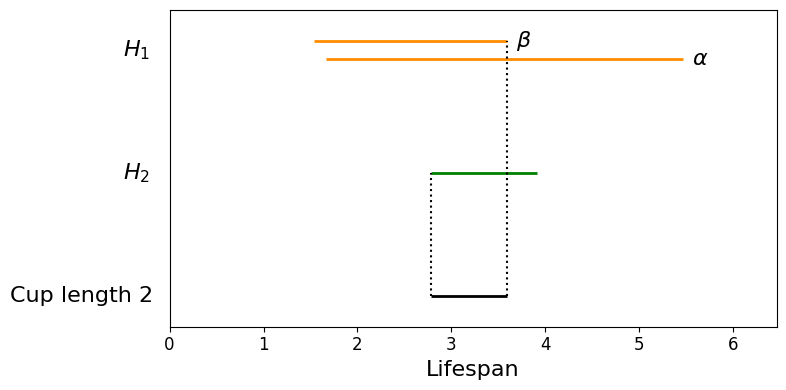

In [ ]:
def plot_persistent_homology_barcodes(ph_data, cup_interval=None, y_offset=2, bar_spacing=0.3):
    color_cycle = ['#FF8C00', 'green', 'black']

    plt.figure(figsize=(8, 4))
    max_x = 0

    # Dictionary to store endpoints of bars for vertical lines
    bar_ends = {
        'orange': [],  # store all H0 bars
        'green': []    # store all H1 bars
    }

    # Plot each homology dimension
    for dim, arr in enumerate(ph_data):
        # Sort by persistence
        if arr.size > 0:
            persistence = arr[:, 1] - arr[:, 0]
            idx_sorted = np.argsort(persistence)[::-1]
            sorted_arr = arr[idx_sorted]
        else:
            sorted_arr = arr

        n = len(sorted_arr)
        y_base = -dim * y_offset

        if n > 0:
            offsets = np.linspace(-bar_spacing * (n - 1) / 2,
                                  bar_spacing * (n - 1) / 2,
                                  n)
            y_positions = y_base + offsets

            color = color_cycle[dim % len(color_cycle)]
            for i, ((b, d), y) in enumerate(zip(sorted_arr, y_positions)):
                plt.hlines(y, b, d, color=color, linewidth=2)
                max_x = max(max_x, d)

                if dim == 0:
                    if i < 2:
                        label = r"$\alpha$" if i == 0 else r"$\beta$"
                        plt.text(d + 0.1, y, label, va='center', fontsize=16)
                    bar_ends['orange'].append((b, d, y))

                if dim == 1:
                    bar_ends['green'].append((b, d, y))

        plt.text(-0.5, y_base, f"$H_{{{dim + 1}}}$", va='center', fontsize=16, fontweight='bold')

    # Always reserve label position for Cup length 2
    y_cup = -len(ph_data) * y_offset
    plt.text(-1.7, y_cup, "Cup length 2", va='center', fontsize=16)

    if cup_interval is not None:
        cup_left, cup_right = cup_interval
        plt.hlines(y_cup, cup_left, cup_right, color='black', linewidth=2)
        max_x = max(max_x, cup_right)

        # Find matching orange bar ending at cup_right
        for (b, d, y) in bar_ends['orange']:
            if np.isclose(d, cup_right):
                plt.vlines(cup_right, y_cup, y, linestyle='dotted', color='black', linewidth=1.5)
                break

        # Find matching green bar starting at cup_left
        for (b, d, y) in bar_ends['green']:
            if np.isclose(b, cup_left):
                plt.vlines(cup_left, y_cup, y, linestyle='dotted', color='black', linewidth=1.5)
                break

    top_offset = 0
    if ph_data and len(ph_data[0]) > 1:
        top_offset = bar_spacing * (len(ph_data[0]) - 1) / 2
    y_top = 0 + top_offset
    plt.ylim(y_cup - 0.5, y_top + 0.5)
    plt.xlabel("Lifespan", fontsize=16)  # Increase font size of x-axis label
    plt.xticks(fontsize=12)              # Increase font size of x-axis tick labels
    plt.yticks([], fontsize=12)
    plt.xlim(0, max_x + 1)
    plt.yticks([])

    plt.tight_layout()
    plt.show()


def top_persistent_bars(dgm, top_k):
    return sorted(dgm, key=lambda x: x[1] - x[0], reverse=True)[:top_k]

# Extract top persistent bars
top_H1 = top_persistent_bars(dgms[1], 2)  # Top 2 from H1
top_H2 = top_persistent_bars(dgms[2], 1)  # Top 1 from H2


ph_data = [
    np.array(top_H1),  # H1
    np.array(top_H2)   # H2
]

plot_persistent_homology_barcodes(ph_data, cup_interval=cup_lengths_2[0])

# Torus with a sphere attached

In this example, we consider a torus with a sphere attached to it at a single point (i.e. $T^2 \vee S^2$). Here, the true toroidal structure arises from the two most persistent 1-dimensional bars and the second most persistent 2-dimensional bar. This code was used to create Figure 3 in our paper.

Computed rips filtration in 0.07 mins


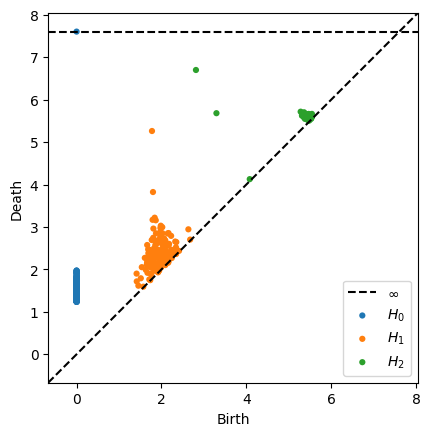

Minimum persistence:  0
cup length 2 interval: (3.296602249145508, 3.82485032081604)
Persistent cup length algorithm took 0.86 minutes to run.


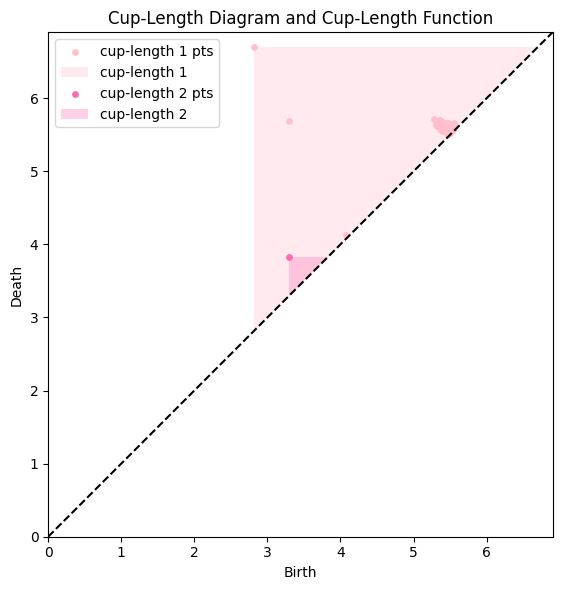

Critical points (cup-length 2): [(3.296602249145508, 3.82485032081604)]
Polygon vertices (cup-length 2): [[(3.296602249145508, 3.296602249145508), (3.296602249145508, 3.82485032081604), (3.82485032081604, 3.82485032081604)]]


In [ ]:
def sample_torus(n_points, R, r):
    """
    Randomly sample points on a torus.

    Parameters:
      n_points : int
          Number of points to sample.
      R : float
          Major radius (distance from center of tube to center of torus).
      r : float
          Minor radius (radius of the tube).

    Returns:
      (n_points x 3) numpy array of sampled points on the torus.
    """
    theta = 2 * np.pi * np.random.random(n_points)
    phi = 2 * np.pi * np.random.random(n_points)
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    return np.column_stack((x, y, z))

def generate_torus_sphere_point_cloud(n_torus_points=1000, n_sphere=1000,
                                        torus_R=5.0, torus_r=1.0, sphere_radius=0.5):
    """
    Generates a point cloud for a torus with an attached sphere that is tangent at exactly one point.

    The torus is generated by randomly sampling points using `sample_torus`.
    The sphere is placed so that it is externally tangent to the torus at (R + r, 0, 0).
    Thus, its center is at (R + r + sphere_radius, 0, 0).
    """
    # 1. Generate torus points randomly
    torus_points = sample_torus(n_torus_points, torus_R, torus_r)

    # 2. The tangent point on the torus is (R + r, 0, 0).
    #    To have the sphere tangent at that point, place the sphere's center at
    #    (R + r + sphere_radius, 0, 0).
    sphere_center = np.array([torus_R + torus_r + sphere_radius, 0, 0])

    # 3. Generate sphere points using spherical coordinates, then shift them by sphere_center.
    phi = np.random.uniform(0, 2 * np.pi, n_sphere)
    costheta = np.random.uniform(-1, 1, n_sphere)
    theta = np.arccos(costheta)

    x_sphere = sphere_radius * np.sin(theta) * np.cos(phi) + sphere_center[0]
    y_sphere = sphere_radius * np.sin(theta) * np.sin(phi) + sphere_center[1]
    z_sphere = sphere_radius * np.cos(theta) + sphere_center[2]
    sphere_points = np.column_stack((x_sphere, y_sphere, z_sphere))

    # 4. Combine the torus and sphere point clouds
    point_cloud = np.vstack([torus_points, sphere_points])
    return point_cloud

# Generate the point cloud
T2_S2_cloud = generate_torus_sphere_point_cloud(
    n_torus_points=1000, n_sphere=1000,
    torus_R=5.0, torus_r=3.0, sphere_radius=4
)


# Visualize using Plotly's go.Figure
fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=T2_S2_cloud[:, 0],
    y=T2_S2_cloud[:, 1],
    z=T2_S2_cloud[:, 2],
    mode='markers',
    marker=dict(size=2, color='#ff69b4', opacity=0.8),
    name='Torus with Externally Tangent Sphere'
))


fig.update_layout(
    title=r' Torus with a sphere attached',
    scene=dict(
        xaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        yaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        ),
        zaxis=dict(
            showbackground=False,
            showticklabels=False,
            showgrid=False,
            zeroline=False,
            visible=False
        )
    ),
    paper_bgcolor="white",
    plot_bgcolor="white"
)

fig.show()

dgms, cup_lengths_2, persistent_cup_length_matrix, b_times, d_times = run_persistence_cup_length_algorithm(T2_S2_cloud, 250)



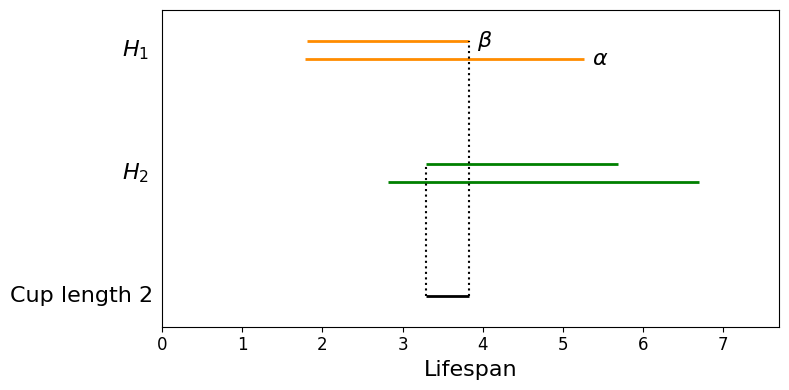

In [ ]:
# 1-bars
sorted_bars = sorted(dgms[1], key=lambda x: x[1] - x[0], reverse=True)

# Select the top two by persistence
top_two_bars = sorted_bars[:2]

# 2-bars
sorted_bars = sorted(dgms[2], key=lambda x: x[1] - x[0], reverse=True)

# Select the top two by persistence
h2 = sorted_bars[:2]


def plot_persistent_homology_barcodes(ph_data, cup_interval=None, y_offset=2, bar_spacing=0.3):
    color_cycle = ['#FF8C00', 'green', 'black']

    plt.figure(figsize=(8, 4))
    max_x = 0

    # Dictionary to store endpoints of bars for vertical lines
    bar_ends = {
        'orange': [],  # store all H0 bars
        'green': []    # store all H1 bars
    }

    # Plot each homology dimension
    for dim, arr in enumerate(ph_data):
        # Sort by persistence
        if arr.size > 0:
            persistence = arr[:, 1] - arr[:, 0]
            idx_sorted = np.argsort(persistence)[::-1]
            sorted_arr = arr[idx_sorted]
        else:
            sorted_arr = arr

        n = len(sorted_arr)
        y_base = -dim * y_offset

        if n > 0:
            offsets = np.linspace(-bar_spacing * (n - 1) / 2,
                                  bar_spacing * (n - 1) / 2,
                                  n)
            y_positions = y_base + offsets

            color = color_cycle[dim % len(color_cycle)]
            for i, ((b, d), y) in enumerate(zip(sorted_arr, y_positions)):
                plt.hlines(y, b, d, color=color, linewidth=2)
                max_x = max(max_x, d)

                if dim == 0:
                    if i < 2:
                        label = r"$\alpha$" if i == 0 else r"$\beta$"
                        plt.text(d + 0.1, y, label, va='center', fontsize=16)
                    bar_ends['orange'].append((b, d, y))

                if dim == 1:
                    bar_ends['green'].append((b, d, y))

        plt.text(-0.5, y_base, f"$H_{{{dim + 1}}}$", va='center', fontsize=16, fontweight='bold')

    # Always reserve label position for Cup length 2
    y_cup = -len(ph_data) * y_offset
    plt.text(-1.9, y_cup, "Cup length 2", va='center', fontsize=16)

    if cup_interval is not None:
        cup_left, cup_right = cup_interval
        plt.hlines(y_cup, cup_left, cup_right, color='black', linewidth=2)
        max_x = max(max_x, cup_right)

        # Find matching orange bar ending at cup_right
        for (b, d, y) in bar_ends['orange']:
            if np.isclose(d, cup_right):
                plt.vlines(cup_right, y_cup, y, linestyle='dotted', color='black', linewidth=1.5)
                break

        # Find matching green bar starting at cup_left
        for (b, d, y) in bar_ends['green']:
            if np.isclose(b, cup_left):
                plt.vlines(cup_left, y_cup, y, linestyle='dotted', color='black', linewidth=1.5)
                break

    top_offset = 0
    if ph_data and len(ph_data[0]) > 1:
        top_offset = bar_spacing * (len(ph_data[0]) - 1) / 2
    y_top = 0 + top_offset
    plt.ylim(y_cup - 0.5, y_top + 0.5)
    plt.xlabel("Lifespan", fontsize=16)  # Increase font size of x-axis label
    plt.xticks(fontsize=12)              # Increase font size of x-axis tick labels
    plt.yticks([], fontsize=12)
    plt.xlim(0, max_x + 1)
    plt.yticks([])

    plt.tight_layout()
    plt.show()





ph_data_example = [
        np.array(top_two_bars),  # H1
        np.array(h2)            # H2
    ]

plot_persistent_homology_barcodes(ph_data_example, cup_interval=cup_lengths_2[0])

# Torus with a cap removed

In this example, we sample points from a torus but deliberately remove a “cap” — a patch of surface defined by restricting one or both of the torus’s angular coordinates (θ and/or φ) to lie within a given interval. Because this defect delays the appearance of the toroidal loop in the Vietoris–Rips filtration, the persistence diagram by itself may not reveal that the data originally came from a torus with a missing patch. Nevertheless, our method still uncovers a cup‐length-2 interval,  signaling the underlying toroidal topology.

Computed rips filtration in 0.05 mins


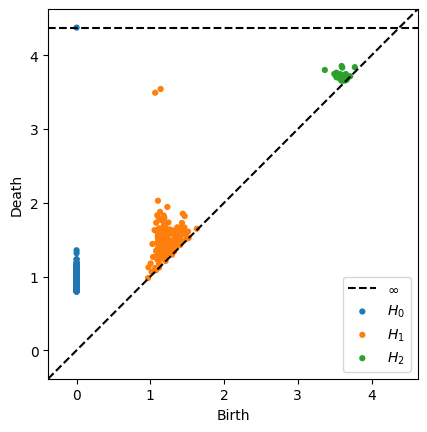

Minimum persistence:  0
cup length 2 interval: (3.36639666557312, 3.492994785308838)
Persistent cup length algorithm took 4.96 minutes to run.


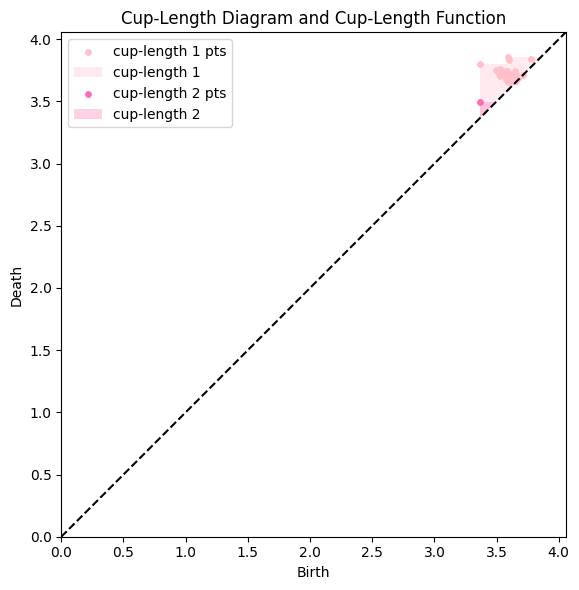

Critical points (cup-length 2): [(3.36639666557312, 3.492994785308838)]
Polygon vertices (cup-length 2): [[(3.36639666557312, 3.36639666557312), (3.36639666557312, 3.492994785308838), (3.492994785308838, 3.492994785308838)]]


In [ ]:
import numpy as np
import plotly.graph_objects as go

def torus_point(theta, phi, R, r):
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    return x, y, z

def sample_torus_with_missing_cap(n_points, R, r, theta_cap, phi_cap, seed=42):
    rng = np.random.default_rng(seed)
    pts = []
    while len(pts) < n_points:
        θ = rng.uniform(0, 2*np.pi)
        φ = rng.uniform(0, 2*np.pi)
        if theta_cap[0] <= θ <= theta_cap[1] and phi_cap[0] <= φ <= phi_cap[1]:
            continue
        pts.append(torus_point(θ, φ, R, r))
    return np.array(pts)

# Parameters
n_points  = 2000
R, r      = 4, 2
theta_cap = (0,    np.pi/4)
phi_cap   = (0,    np.pi/2)

# 1. Sample torus minus cap
torus_pts = sample_torus_with_missing_cap(n_points, R, r, theta_cap, phi_cap)

# 2. Build a grid over the cap region
n_grid = 50
ths = np.linspace(theta_cap[0], theta_cap[1], n_grid)
phs = np.linspace(phi_cap[0],   phi_cap[1],   n_grid)
Θ, Φ = np.meshgrid(ths, phs)

# 3. Map grid to 3D coordinates
X, Y, Z = torus_point(Θ, Φ, R, r)

# 4. Flatten for Mesh3d
x_flat = X.ravel()
y_flat = Y.ravel()
z_flat = Z.ravel()

# 5. Plot
fig = go.Figure()

# Pink torus points
fig.add_trace(go.Scatter3d(
    x=torus_pts[:,0], y=torus_pts[:,1], z=torus_pts[:,2],
    mode='markers',
    marker=dict(size=2, color='#ff69b4', opacity=0.8),
    name='Torus (cap removed)'
))

# Blue shaded cap mesh
fig.add_trace(go.Mesh3d(
    x=x_flat, y=y_flat, z=z_flat,
    color='blue',
    opacity=0.4,
    alphahull=0,
    name='Excluded Cap'
))

fig.update_layout(
    title='Torus with Cap Removed (blue shaded region is the missing cap)',
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False)
    ),
    margin=dict(l=0, r=0, t=40, b=0),
    paper_bgcolor='white',
    plot_bgcolor='white'
)

fig.show()

dgms, cup_lengths_2, persistent_cup_length_matrix, b_times, d_times  = run_persistence_cup_length_algorithm(torus_pts, 250)

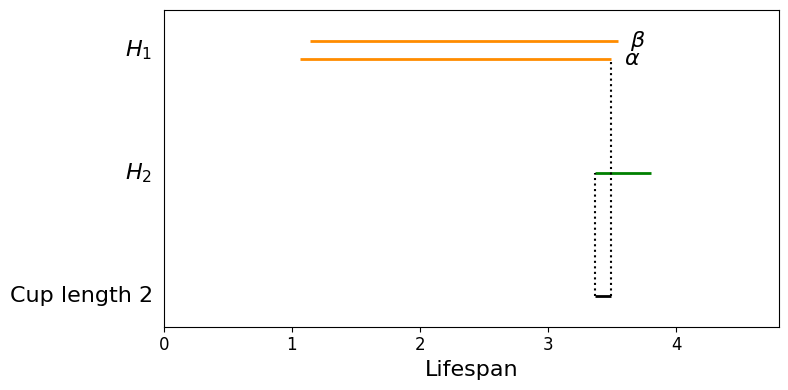

In [ ]:
def plot_persistent_homology_barcodes(ph_data, cup_interval=None, y_offset=2, bar_spacing=0.3):
    color_cycle = ['#FF8C00', 'green', 'black']

    plt.figure(figsize=(8, 4))
    max_x = 0

    # Dictionary to store endpoints of bars for vertical lines
    bar_ends = {
        'orange': [],  # store all H0 bars
        'green': []    # store all H1 bars
    }

    # Plot each homology dimension
    for dim, arr in enumerate(ph_data):
        # Sort by persistence
        if arr.size > 0:
            persistence = arr[:, 1] - arr[:, 0]
            idx_sorted = np.argsort(persistence)[::-1]
            sorted_arr = arr[idx_sorted]
        else:
            sorted_arr = arr

        n = len(sorted_arr)
        y_base = -dim * y_offset

        if n > 0:
            offsets = np.linspace(-bar_spacing * (n - 1) / 2,
                                  bar_spacing * (n - 1) / 2,
                                  n)
            y_positions = y_base + offsets

            color = color_cycle[dim % len(color_cycle)]
            for i, ((b, d), y) in enumerate(zip(sorted_arr, y_positions)):
                plt.hlines(y, b, d, color=color, linewidth=2)
                max_x = max(max_x, d)

                if dim == 0:
                    if i < 2:
                        label = r"$\alpha$" if i == 0 else r"$\beta$"
                        plt.text(d + 0.1, y, label, va='center', fontsize=16)
                    bar_ends['orange'].append((b, d, y))

                if dim == 1:
                    bar_ends['green'].append((b, d, y))

        plt.text(-0.3, y_base, f"$H_{{{dim + 1}}}$", va='center', fontsize=16, fontweight='bold')

    # Always reserve label position for Cup length 2
    y_cup = -len(ph_data) * y_offset
    plt.text(-1.2, y_cup, "Cup length 2", va='center', fontsize=16)

    if cup_interval is not None:
        cup_left, cup_right = cup_interval
        plt.hlines(y_cup, cup_left, cup_right, color='black', linewidth=2)
        max_x = max(max_x, cup_right)

        # Find matching orange bar ending at cup_right
        for (b, d, y) in bar_ends['orange']:
            if np.isclose(d, cup_right):
                plt.vlines(cup_right, y_cup, y, linestyle='dotted', color='black', linewidth=1.5)
                break

        # Find matching green bar starting at cup_left
        for (b, d, y) in bar_ends['green']:
            if np.isclose(b, cup_left):
                plt.vlines(cup_left, y_cup, y, linestyle='dotted', color='black', linewidth=1.5)
                break

    # Axes and limits

    top_offset = 0
    if ph_data and len(ph_data[0]) > 1:
        top_offset = bar_spacing * (len(ph_data[0]) - 1) / 2
    y_top = 0 + top_offset
    plt.ylim(y_cup - 0.5, y_top + 0.5)
    plt.xlabel("Lifespan", fontsize=16)  # Increase font size of x-axis label
    plt.xticks(fontsize=12)              # Increase font size of x-axis tick labels
    plt.yticks([], fontsize=12)
    plt.xlim(0, max_x + 1)
    plt.yticks([])

    plt.tight_layout()
    plt.show()


def top_persistent_bars(dgm, top_k):
    return sorted(dgm, key=lambda x: x[1] - x[0], reverse=True)[:top_k]

# Extract top persistent bars
top_H1 = top_persistent_bars(dgms[1], 2)  # Top 2 from H1
top_H2 = top_persistent_bars(dgms[2], 1)  # Top 1 from H2


ph_data = [
    np.array(top_H1),  # H1
    np.array(top_H2)   # H2
]

plot_persistent_homology_barcodes(ph_data, cup_interval=cup_lengths_2[0])

# Asymmetric torus

In this example, we sample 2,000 points from a torus whose minor radius has been locally enlarged along one generating circle. Although its persistence diagram still contains two long-lived 1-bars and one long-lived 2-bar, the cup–length-2 interval is very short. Hence, while the existence of a cup–length-2 interval confirms toroidal topology, its lifetime also reflects geometric deformation. In the standard torus, this interval persists over a longer period in the Vietoris–Rips filtration, but when one cycle is expanded, it appears only transiently. This nuanced perspective aids in interpreting experimental results on real data.

In [ ]:
def sample_torus_with_fat_region(n_points, R, r,
                                        r_fat=3.0,
                                        fat_center=0.0,  # angle in radians
                                        seed=42):
    """
    Sample points on a torus with smoothly fattened region around `fat_center`.

    Parameters:
      n_points : int
      R : float — major radius
      r : float — base minor radius
      r_fat : float — peak fat radius (only on one side)
      fat_center : float — angle (θ) in radians where fatness peaks
      seed : int — reproducibility

    Returns:
      np.ndarray of shape (n_points, 3)
    """
    rng = np.random.default_rng(seed)
    theta = rng.uniform(0, 2 * np.pi, size=n_points)
    phi = rng.uniform(0, 2 * np.pi, size=n_points)

    delta_r = r_fat - r
    r_theta = r + delta_r * (1 + np.cos(theta - fat_center)) / 2

    x = (R + r_theta * np.cos(phi)) * np.cos(theta)
    y = (R + r_theta * np.cos(phi)) * np.sin(theta)
    z = r_theta * np.sin(phi)

    return np.column_stack((x, y, z))

Computed rips filtration in 0.14 mins


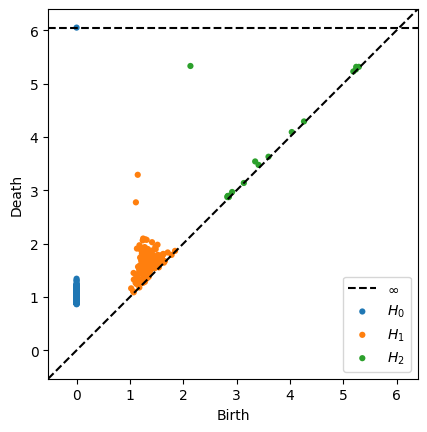

Minimum persistence:  0
cup length 2 interval: (2.1347579956054688, 2.77459716796875)
Persistent cup length algorithm took 1.61 minutes to run.


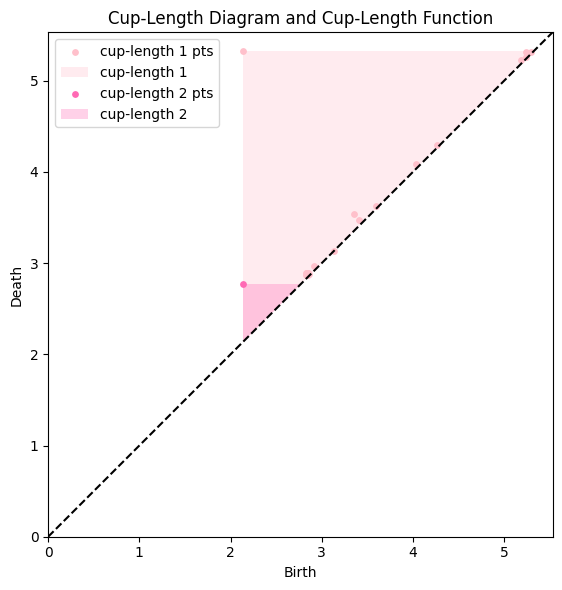

Critical points (cup-length 2): [(2.1347579956054688, 2.77459716796875)]
Polygon vertices (cup-length 2): [[(2.1347579956054688, 2.1347579956054688), (2.1347579956054688, 2.77459716796875), (2.77459716796875, 2.77459716796875)]]


In [ ]:
data = sample_torus_with_fat_region(
    n_points=2000,
    R=4,
    r=1.5,
    r_fat=3.0,
    fat_center=0.0,  # fattest on right-hand side
    seed=2024
)


# Visualize using Plotly's go.Figure
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=data[:, 0],
    y=data[:, 1],
    z=data[:, 2],
    mode='markers',
    marker=dict(
        size=2,
        color='#ff69b4',
        opacity=0.8
    ),
    name=r'$S^1 \times S^1$'
))



fig.update_layout(
    scene=dict(
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
        zaxis=dict(visible=False),
    ),
    margin=dict(l=0,r=0,b=0,t=30),
    paper_bgcolor='white',
)

fig.show()


dgms, cup_lengths_2, persistent_cup_length_matrix, b_times, d_times  = run_persistence_cup_length_algorithm(data, 150)


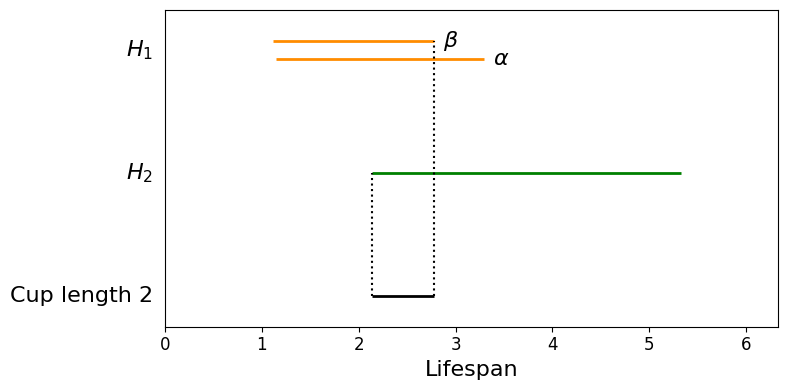

In [ ]:
def plot_persistent_homology_barcodes(ph_data, cup_interval=None, y_offset=2, bar_spacing=0.3):
    color_cycle = ['#FF8C00', 'green', 'black']

    plt.figure(figsize=(8, 4))
    max_x = 0

    # Dictionary to store endpoints of bars for vertical lines
    bar_ends = {
        'orange': [],  # store all H0 bars
        'green': []    # store all H1 bars
    }

    # Plot each homology dimension
    for dim, arr in enumerate(ph_data):
        # Sort by persistence
        if arr.size > 0:
            persistence = arr[:, 1] - arr[:, 0]
            idx_sorted = np.argsort(persistence)[::-1]
            sorted_arr = arr[idx_sorted]
        else:
            sorted_arr = arr

        n = len(sorted_arr)
        y_base = -dim * y_offset

        if n > 0:
            offsets = np.linspace(-bar_spacing * (n - 1) / 2,
                                  bar_spacing * (n - 1) / 2,
                                  n)
            y_positions = y_base + offsets

            color = color_cycle[dim % len(color_cycle)]
            for i, ((b, d), y) in enumerate(zip(sorted_arr, y_positions)):
                plt.hlines(y, b, d, color=color, linewidth=2)
                max_x = max(max_x, d)

                if dim == 0:
                    if i < 2:
                        label = r"$\alpha$" if i == 0 else r"$\beta$"
                        plt.text(d + 0.1, y, label, va='center', fontsize=16)
                    bar_ends['orange'].append((b, d, y))

                if dim == 1:
                    bar_ends['green'].append((b, d, y))

        plt.text(-0.4, y_base, f"$H_{{{dim + 1}}}$", va='center', fontsize=16, fontweight='bold')

    # Always reserve label position for Cup length 2
    y_cup = -len(ph_data) * y_offset
    plt.text(-1.6, y_cup, "Cup length 2", va='center', fontsize=16)

    if cup_interval is not None:
        cup_left, cup_right = cup_interval
        plt.hlines(y_cup, cup_left, cup_right, color='black', linewidth=2)
        max_x = max(max_x, cup_right)

        # Find matching orange bar ending at cup_right
        for (b, d, y) in bar_ends['orange']:
            if np.isclose(d, cup_right):
                plt.vlines(cup_right, y_cup, y, linestyle='dotted', color='black', linewidth=1.5)
                break

        # Find matching green bar starting at cup_left
        for (b, d, y) in bar_ends['green']:
            if np.isclose(b, cup_left):
                plt.vlines(cup_left, y_cup, y, linestyle='dotted', color='black', linewidth=1.5)
                break

    # Axes and limits

    top_offset = 0
    if ph_data and len(ph_data[0]) > 1:
        top_offset = bar_spacing * (len(ph_data[0]) - 1) / 2
    y_top = 0 + top_offset
    plt.ylim(y_cup - 0.5, y_top + 0.5)
    plt.xlabel("Lifespan", fontsize=16)  # Increase font size of x-axis label
    plt.xticks(fontsize=12)              # Increase font size of x-axis tick labels
    plt.yticks([], fontsize=12)
    plt.xlim(0, max_x + 1)
    plt.yticks([])

    plt.tight_layout()
    plt.show()


def top_persistent_bars(dgm, top_k):
    return sorted(dgm, key=lambda x: x[1] - x[0], reverse=True)[:top_k]

# Extract top persistent bars
top_H1 = top_persistent_bars(dgms[1], 2)  # Top 2 from H1
top_H2 = top_persistent_bars(dgms[2], 1)  # Top 1 from H2


ph_data = [
    np.array(top_H1),  # H1
    np.array(top_H2)   # H2
]

plot_persistent_homology_barcodes(ph_data, cup_interval=cup_lengths_2[0])